##아래의 모든 모델에서 지정할 신뢰구간을 먼저 설정하고 사용해 보세요

In [16]:
#바꿔볼 정규분포 신뢰구간(90% = 1.645,95% = 1.96, 99% = 2.575, 99.7% = 3)
X=float(1.96)

## 세분화 이후 Xgboost 돌린 모델

/tmp/ipython-input-1617644343.py:32: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_cleaned = df.groupby(['age_group', 'smoker', 'bmi_cat'], group_keys=False).apply(remove_group_outliers)
/tmp/ipython-input-1617644343.py:32: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_cleaned = df.groupby(['age_group', 'smoker', 'bmi_cat'], group_keys=False).apply(remove_group_outliers)


------------------------------
📊 최종 결과 보고서
이상치 제거 후 데이터 수: 1247
결정계수 (R2 Score): 0.9729
평균 절대 오차 (MAE): 716.62
------------------------------


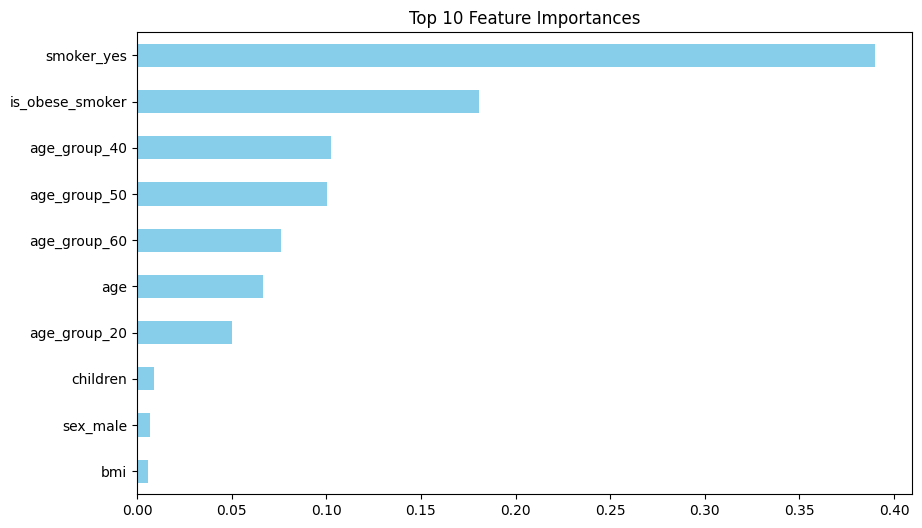

In [ ]:
import pandas as pd
import numpy as np
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_absolute_error

# 1. 데이터 로드
df = pd.read_csv('insurance.csv')

# 2. 특성 공학 (Feature Engineering)
# 나이대 (10단위)
df['age_group'] = (df['age'] // 10) * 10

# BMI 카테고리 분류 (정교한 구간 설정)
bins = [0, 18.5, 23, 25, 30, float('inf')]
labels = ['Underweight', 'Normal', 'Overweight', 'Pre-obese', 'Obese']
df['bmi_cat'] = pd.cut(df['bmi'], bins=bins, labels=labels)

# 핵심 변수: 고비만 흡연자 (BMI 30이상 & Smoker)
df['is_obese_smoker'] = ((df['bmi'] >= 30) & (df['smoker'] == 'yes')).astype(int)

# 3. 세부 그룹별 이상치 제거 (95% 신뢰구간 기준)
def remove_group_outliers(group):
    if len(group) < 5:  # 샘플이 너무 적으면 이상치 계산 생략
        return group
    mean, std = group['charges'].mean(), group['charges'].std()
    lower, upper = mean - X * std, mean + X * std
    return group[(group['charges'] >= lower) & (group['charges'] <= upper)]

df_cleaned = df.groupby(['age_group', 'smoker', 'bmi_cat'], group_keys=False).apply(remove_group_outliers)

# 4. 인코딩 및 학습 준비
# 범주형 데이터 원-핫 인코딩
df_final = pd.get_dummies(df_cleaned, columns=['sex', 'smoker', 'region', 'bmi_cat', 'age_group'], drop_first=True)

# 타겟 변수 로그 변환 (Charges의 왜도 해결)
X = df_final.drop(['charges'], axis=1)
y = np.log1p(df_final['charges'])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 5. XGBoost 모델 학습
model = xgb.XGBRegressor(
    n_estimators=1000,
    learning_rate=0.03,
    max_depth=4,
    subsample=0.8,
    colsample_bytree=0.8,
    early_stopping_rounds=50,
    random_state=42
)

model.fit(X_train, y_train, eval_set=[(X_test, y_test)], verbose=False)

# 6. 평가 및 결과 역변환 (Log -> Original)
y_pred_log = model.predict(X_test)
y_pred = np.expm1(y_pred_log)
y_test_orig = np.expm1(y_test)

print("-" * 30)
print(f"📊 최종 결과 보고서")
print(f"이상치 제거 후 데이터 수: {len(df_cleaned)}")
print(f"결정계수 (R2 Score): {r2_score(y_test_orig, y_pred):.4f}")
print(f"평균 절대 오차 (MAE): {mean_absolute_error(y_test_orig, y_pred):.2f}")
print("-" * 30)

# 7. 변수 중요도 시각화
plt.figure(figsize=(10, 6))
importances = pd.Series(model.feature_importances_, index=X.columns)
importances.nlargest(10).sort_values().plot(kind='barh', color='skyblue')
plt.title('Top 10 Feature Importances')
plt.show()

##전처리 과정은 유지, 흡연팀과 비흡연팀을 나눠서 학습 통합한 모델


X값을 바꾸면서 전처리 범위를 변경 가능합니다

In [ ]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_absolute_error







# 1. 데이터 로드 및 기본 전처리
df = pd.read_csv('insurance.csv')
df['age_group'] = (df['age'] // 10) * 10
bins = [0, 18.5, 23, 25, 30, float('inf')]
labels = ['Underweight', 'Normal', 'Overweight', 'Pre-obese', 'Obese']
df['bmi_cat'] = pd.cut(df['bmi'], bins=bins, labels=labels)

# 2. 데이터 분리 (흡연팀 vs 비흡연팀)
df_smoker = df[df['smoker'] == 'yes'].copy()
df_non_smoker = df[df['smoker'] == 'no'].copy()

# 3. 각 그룹 내 이상치 제거 함수 (앞서 정한 로직 적용)
def clean_group(data):
    def remove_outliers(group):
        if len(group) < 5: return group
        mean, std = group['charges'].mean(), group['charges'].std()
        return group[(group['charges'] >= mean - X*std) & (group['charges'] <= mean + X*std)]
    return data.groupby(['age_group', 'bmi_cat'], group_keys=False).apply(remove_outliers)

df_smoker_cleaned = clean_group(df_smoker)
df_non_smoker_cleaned = clean_group(df_non_smoker)

# 4. 학습 준비 함수 (인코딩 및 로그변환)
def prepare_data(data):
    # 비흡연팀은 smoker 컬럼이 의미 없으므로 제외, 지역/성별 등은 포함
    dummied = pd.get_dummies(data, columns=['sex', 'region', 'bmi_cat', 'age_group'], drop_first=True)
    if 'smoker' in dummied.columns: dummied = dummied.drop('smoker', axis=1)

    X = dummied.drop(['charges'], axis=1)
    y = np.log1p(dummied['charges'])
    return X, y

# 각 팀 데이터 준비
X_s, y_s = prepare_data(df_smoker_cleaned)
X_ns, y_ns = prepare_data(df_non_smoker_cleaned)

# Train/Test 분리
X_train_s, X_test_s, y_train_s, y_test_s = train_test_split(X_s, y_s, test_size=0.2, random_state=42)
X_train_ns, X_test_ns, y_train_ns, y_test_ns = train_test_split(X_ns, y_ns, test_size=0.2, random_state=42)

# 5. 개별 모델 학습
model_smoker = xgb.XGBRegressor(n_estimators=500, learning_rate=0.05, max_depth=3, random_state=42)
model_non_smoker = xgb.XGBRegressor(n_estimators=500, learning_rate=0.05, max_depth=3, random_state=42)

model_smoker.fit(X_train_s, y_train_s)
model_non_smoker.fit(X_train_ns, y_train_ns)

# 6. 예측 및 결합
pred_s = np.expm1(model_smoker.predict(X_test_s))
pred_ns = np.expm1(model_non_smoker.predict(X_test_ns))

true_s = np.expm1(y_test_s)
true_ns = np.expm1(y_test_ns)

# 두 팀의 결과를 하나로 합치기
all_preds = np.concatenate([pred_s, pred_ns])
all_trues = np.concatenate([true_s, true_ns])

# 7. 통합 성능 평가
print(f"🔥 흡연팀 R2: {r2_score(true_s, pred_s):.4f}")
print(f"🌿 비흡연팀 R2: {r2_score(true_ns, pred_ns):.4f}")
print("-" * 30)
print(f"🏆 통합 최종 R2 Score: {r2_score(all_trues, all_preds):.4f}")
print(f"🏆 통합 최종 MAE: {mean_absolute_error(all_trues, all_preds):.2f}")

/tmp/ipython-input-3130113316.py:28: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  return data.groupby(['age_group', 'bmi_cat'], group_keys=False).apply(remove_outliers)
/tmp/ipython-input-3130113316.py:28: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  return data.groupby(['age_group', 'bmi_cat'], group_keys=False).apply(remove_outliers)
/tmp/ipython-input-3130113316.py:28: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=Fals

🔥 흡연팀 R2: 0.9830
🌿 비흡연팀 R2: 0.8050
------------------------------
🏆 통합 최종 R2 Score: 0.9746
🏆 통합 최종 MAE: 656.85


In [ ]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_absolute_error

# 1. 데이터 로드 및 기본 전처리
df = pd.read_csv('insurance.csv')

# 공통 특성 생성
df['age_group'] = (df['age'] // 10) * 10
bins = [0, 18.5, 23, 25, 30, float('inf')]
labels = ['Underweight', 'Normal', 'Overweight', 'Pre-obese', 'Obese']
df['bmi_cat'] = pd.cut(df['bmi'], bins=bins, labels=labels)

# 2. 데이터 분할 및 팀별 특화 변수 생성
# [흡연팀] 고BMI 흡연자 변수 추가
df_s = df[df['smoker'] == 'yes'].copy()
df_s['is_obese_smoker'] = (df_s['bmi'] >= 30).astype(int)

# [비흡연팀] 나이 곡선(제곱) 및 나이*자녀 상호작용 추가
df_ns = df[df['smoker'] == 'no'].copy()
df_ns['age_sq'] = df_ns['age'] ** 2
df_ns['age_child'] = df_ns['age'] * df_ns['children']

# 3. 그룹별 이상치 제거 (95% 신뢰구간)
def remove_outliers_by_group(data):
    def filter_func(group):
        if len(group) < 5: return group
        mean, std = group['charges'].mean(), group['charges'].std()
        return group[(group['charges'] >= mean - X*std) & (group['charges'] <= mean + X*std)]
    # 나이대와 BMI 카테고리별로 세분화하여 이상치 제거
    return data.groupby(['age_group', 'bmi_cat'], group_keys=False).apply(filter_func)

df_s_cleaned = remove_outliers_by_group(df_s)
df_ns_cleaned = remove_outliers_by_group(df_ns)

# 4. 모델 학습용 데이터 정제 함수
def prepare_model_data(data, is_smoker=True):
    # 범주형 인코딩
    cols_to_dummy = ['sex', 'region', 'bmi_cat', 'age_group']
    dummied = pd.get_dummies(data, columns=cols_to_dummy, drop_first=True)
    if 'smoker' in dummied.columns: dummied = dummied.drop('smoker', axis=1)

    X = dummied.drop(['charges'], axis=1)
    y = np.log1p(dummied['charges']) # 타겟 로그 변환
    return X, y

# 5. 각 팀별 독립 학습
# 흡연팀 학습
X_s, y_s = prepare_model_data(df_s_cleaned, is_smoker=True)
X_train_s, X_test_s, y_train_s, y_test_s = train_test_split(X_s, y_s, test_size=0.2, random_state=42)

model_s = xgb.XGBRegressor(n_estimators=500, learning_rate=0.05, max_depth=4, random_state=42)
model_s.fit(X_train_s, y_train_s)

# 비흡연팀 학습 (강화 모델)
X_ns, y_ns = prepare_model_data(df_ns_cleaned, is_smoker=False)
X_train_ns, X_test_ns, y_train_ns, y_test_ns = train_test_split(X_ns, y_ns, test_size=0.2, random_state=42)

model_ns = xgb.XGBRegressor(n_estimators=1000, learning_rate=0.01, max_depth=3, random_state=42)
model_ns.fit(X_train_ns, y_train_ns)

# 6. 최종 통합 예측 및 성능 평가
pred_s = np.expm1(model_s.predict(X_test_s))
true_s = np.expm1(y_test_s)

pred_ns = np.expm1(model_ns.predict(X_test_ns))
true_ns = np.expm1(y_test_ns)

# 두 결과를 하나로 합침
total_true = np.concatenate([true_s, true_ns])
total_pred = np.concatenate([pred_s, pred_ns])

print("="*40)
print(f"🚬 흡연팀 R2: {r2_score(true_s, pred_s):.4f}")
print(f"🌿 비흡연팀 R2: {r2_score(true_ns, pred_ns):.4f}")
print("-" * 40)
print(f"🏆 전체 통합 R2 Score: {r2_score(total_true, total_pred):.4f}")
print(f"🏆 전체 통합 MAE: {mean_absolute_error(total_true, total_pred):.2f}")
print("="*40)

/tmp/ipython-input-3023902766.py:33: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  return data.groupby(['age_group', 'bmi_cat'], group_keys=False).apply(filter_func)
/tmp/ipython-input-3023902766.py:33: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  return data.groupby(['age_group', 'bmi_cat'], group_keys=False).apply(filter_func)
/tmp/ipython-input-3023902766.py:33: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to ret

🚬 흡연팀 R2: 0.9786
🌿 비흡연팀 R2: 0.8106
----------------------------------------
🏆 전체 통합 R2 Score: 0.9745
🏆 전체 통합 MAE: 663.72


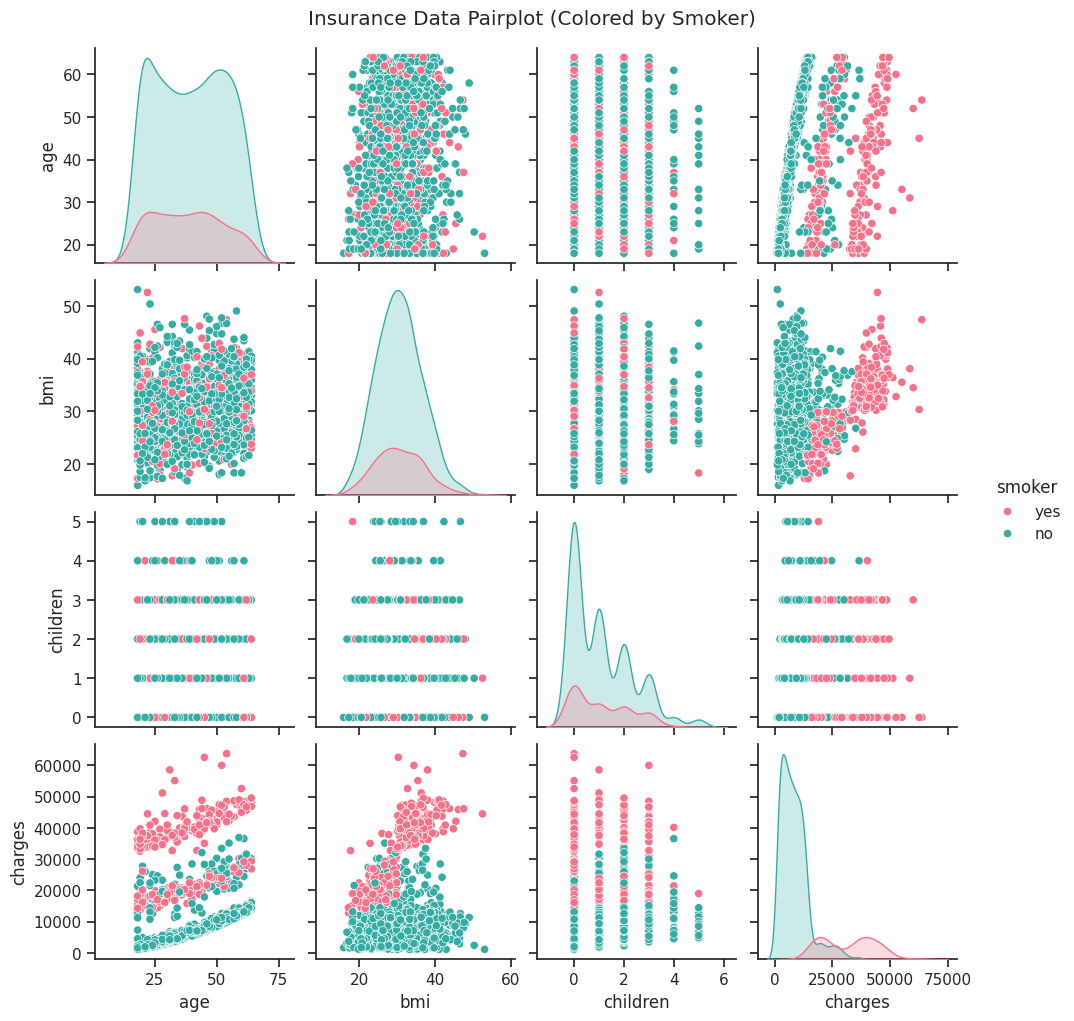

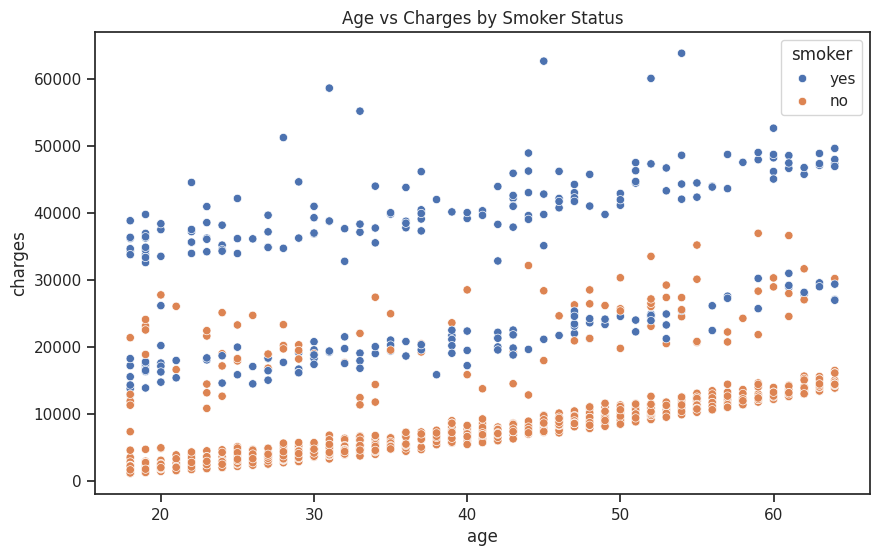

In [11]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# 1. 데이터 불러오기
df = pd.read_csv('insurance.csv')

# 2. 시각화 스타일 설정
sns.set_theme(style="ticks")

# 3. 전체 수치형 변수에 대한 산점도 행렬(Pairplot) 그리기
# 'smoker' 컬럼을 hue로 지정하면 흡연 여부에 따른 차이를 색상으로 구분할 수 있어 분석에 훨씬 유용합니다.
pair_plot = sns.pairplot(df, hue='smoker', palette='husl', diag_kind='kde')

# 제목 추가
pair_plot.fig.suptitle("Insurance Data Pairplot (Colored by Smoker)", y=1.02)

plt.show()

# 4. (선택사항) 특정 변수와 타겟(Charges) 간의 산점도만 따로 보고 싶을 때
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x='age', y='charges', hue='smoker')
plt.title('Age vs Charges by Smoker Status')
plt.show()

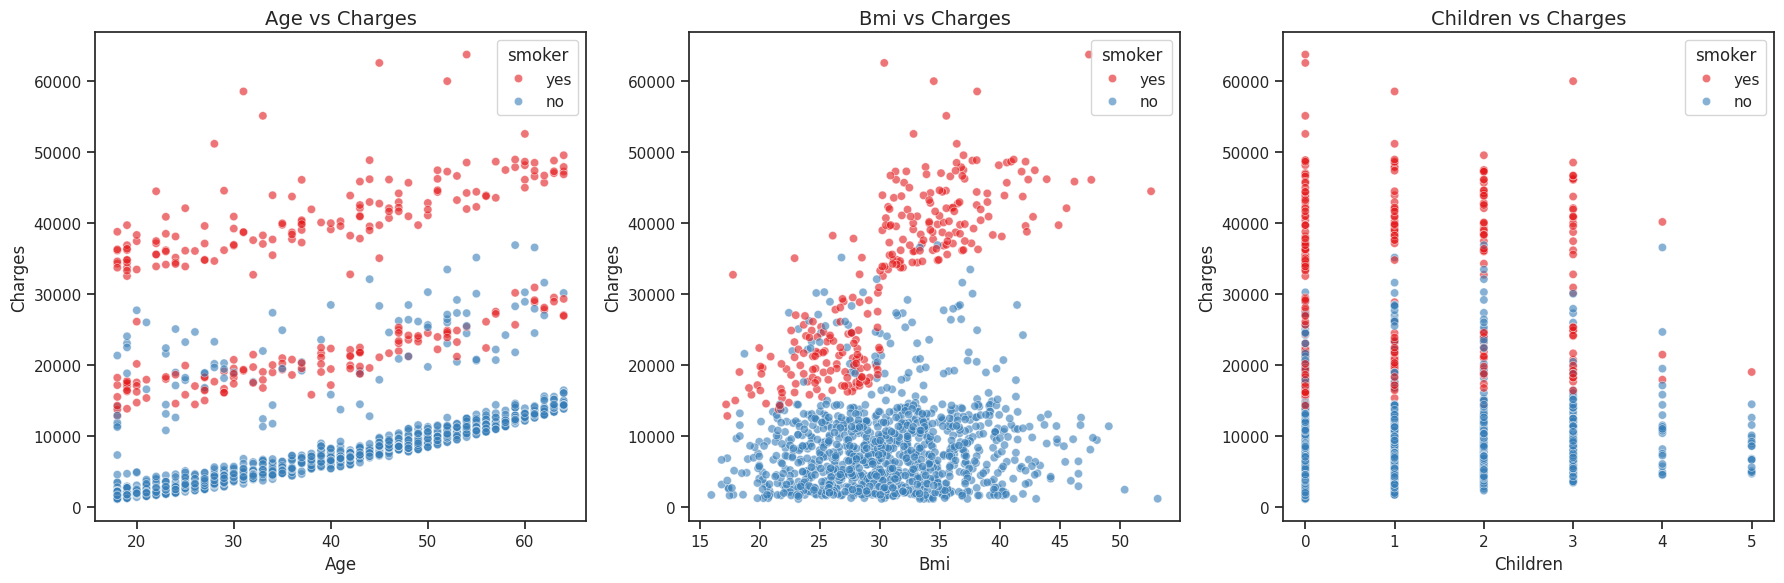

In [12]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# 1. 데이터 불러오기
df = pd.read_csv('insurance.csv')

# 2. 분석할 수치형 변수 리스트 (charges 제외)
features = ['age', 'bmi', 'children']

# 3. 그래프 설정 (1행 3열)
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# 4. 반복문을 이용해 각 변수별 산점도 그리기
for i, col in enumerate(features):
    sns.scatterplot(
        data=df,
        x=col,
        y='charges',
        hue='smoker',
        palette='Set1',
        alpha=0.6,
        ax=axes[i]
    )
    axes[i].set_title(f'{col.capitalize()} vs Charges', fontsize=14)
    axes[i].set_xlabel(col.capitalize())
    axes[i].set_ylabel('Charges')

# 레이아웃 정렬 및 출력
plt.tight_layout()
plt.show()

In [13]:
import pandas as pd
import numpy as np
from scipy import stats

# 1. 데이터 로드
df = pd.read_csv('insurance.csv')

# 2. 영향력 큰 컬럼 추가 (흡연 + 고BMI: 30 이상)
# 흡연자이면서 BMI가 30 이상인 경우를 고위험군으로 분류
df['high_risk_smoker'] = ((df['smoker'] == 'yes') & (df['bmi'] >= 30)).astype(int)

# 3. 연령대 그룹 생성 (10대 단위)
df['age_group'] = (df['age'] // 10) * 10

# 4. BMI 5분법 적용
# 기준: ~18.5(저체중), ~25(정상), ~30(과체중), ~35(비만/전비만), 35~(고도비만)
bmi_bins = [0, 18.5, 25, 30, 35, float('inf')]
bmi_labels = ['Underweight', 'Normal', 'Overweight', 'Obese', 'Extremely Obese']
df['bmi_group'] = pd.cut(df['bmi'], bins=bmi_bins, labels=bmi_labels)

# 5. 세분화된 그룹별 이상치 탐지 (95% 신뢰구간 기준)
# 그룹화: 연령대 + 흡연여부 + BMI등급
group_cols = ['age_group', 'smoker', 'bmi_group']

def flag_outliers(group):
    # 신뢰도 95%는 z-score 기준 약 ±1.96
    # 그룹 내 샘플이 너무 적으면 계산이 무의미하므로 최소 3개 이상일 때만 계산
    if len(group) > 3:
        z_scores = np.abs(stats.zscore(group['charges']))
        # z-score가 1.96보다 크면 상위/하위 2.5% (합쳐서 5%)에 해당
        group['is_outlier'] = (z_scores > 1.96)
    else:
        group['is_outlier'] = False
    return group

# 그룹별로 함수 적용
df = df.groupby(group_cols, group_keys=False).apply(flag_outliers)

# 결과 확인
print(df[['age', 'smoker', 'bmi', 'bmi_group', 'high_risk_smoker', 'is_outlier']].head())
print(f"\n총 이상치 개수: {df['is_outlier'].sum()}개")

   age smoker     bmi   bmi_group  high_risk_smoker  is_outlier
0   19    yes  27.900  Overweight                 0       False
1   18     no  33.770       Obese                 0       False
2   28     no  33.000       Obese                 0       False
3   33     no  22.705      Normal                 0        True
4   32     no  28.880  Overweight                 0       False

총 이상치 개수: 97개


/tmp/ipython-input-605134058.py:37: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df = df.groupby(group_cols, group_keys=False).apply(flag_outliers)
/tmp/ipython-input-605134058.py:37: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.groupby(group_cols, group_keys=False).apply(flag_outliers)


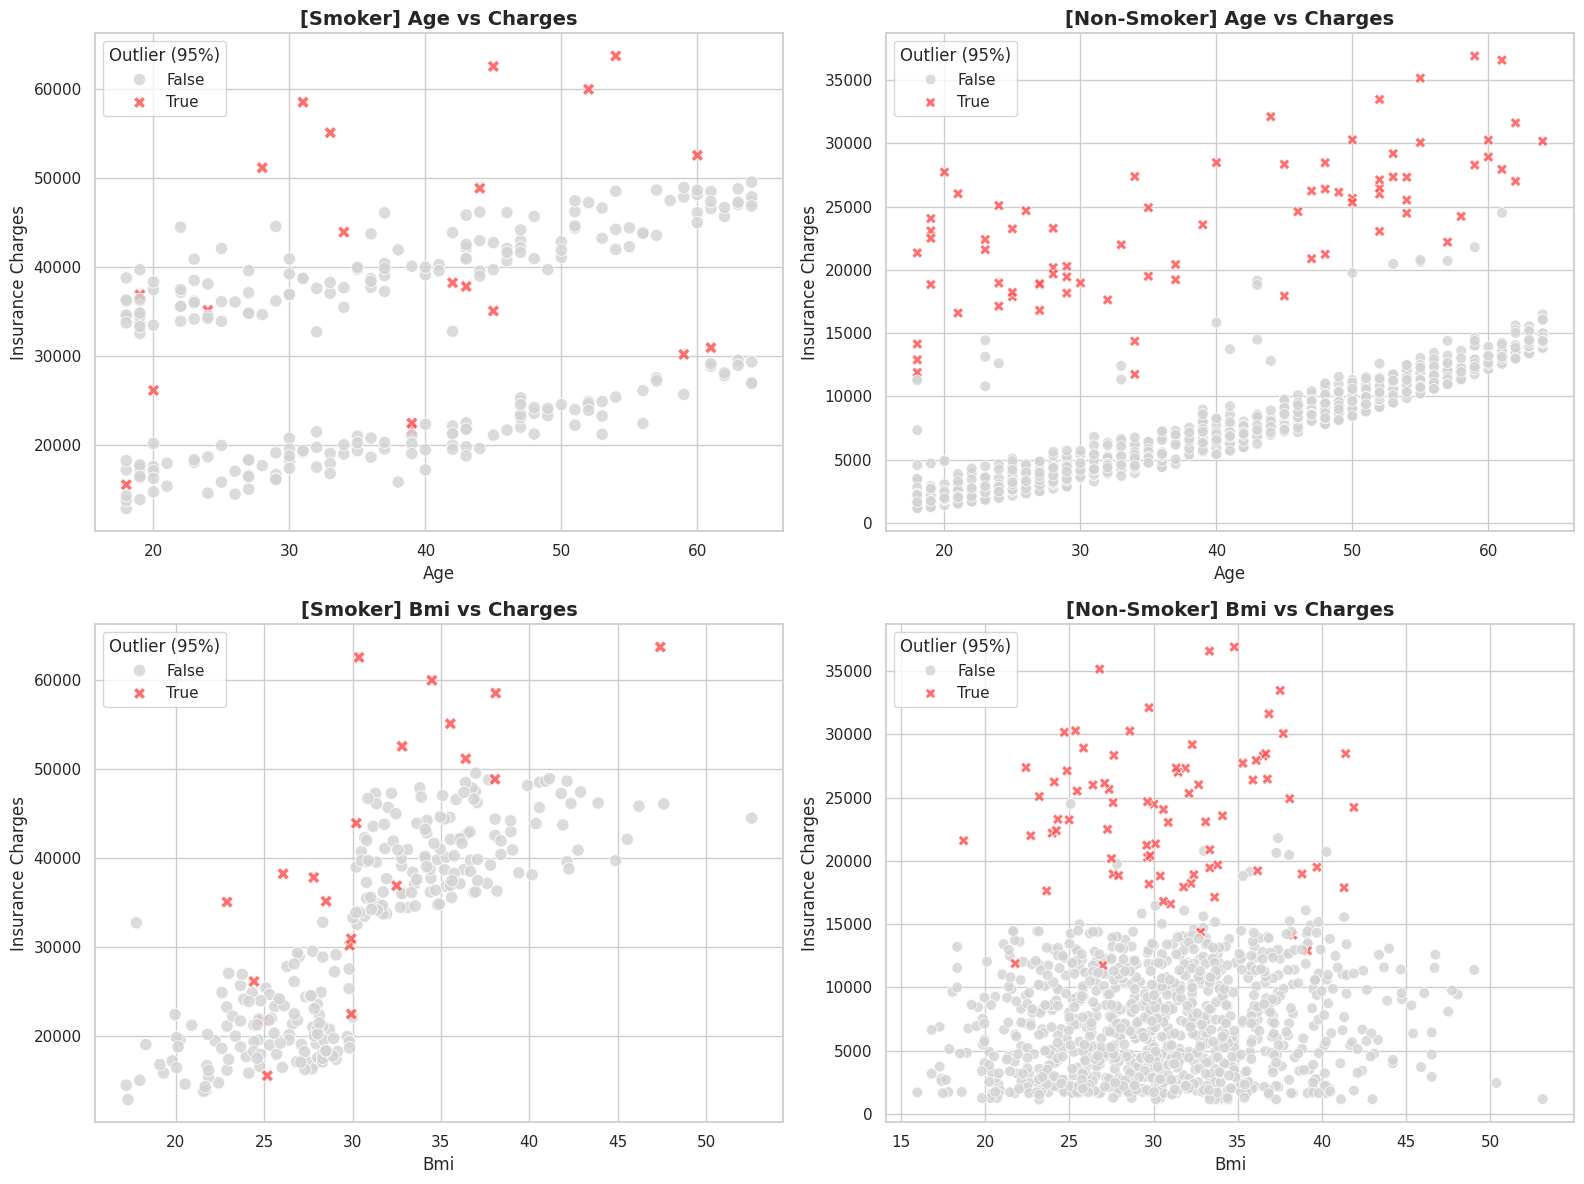

In [20]:
import matplotlib.pyplot as plt
import seaborn as sns

# 시각화 스타일 설정
sns.set_theme(style="whitegrid")

# 분석할 x축 리스트 (나이, BMI)
x_features = ['age', 'bmi']
smoker_types = ['yes', 'no']

# 그래프 생성 (2행 2열: x축 변수 2개 x 흡연여부 2개)
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

for i, x_col in enumerate(x_features):
    for j, smoker_val in enumerate(smoker_types):
        # 해당 조건의 데이터 필터링
        subset = df[df['smoker'] == smoker_val]

        # 산점도 그리기
        # hue='is_outlier'를 사용하여 이상치만 색상을 다르게 지정
        # palette: False는 연한 회색, True는 강렬한 빨간색으로 설정
        sns.scatterplot(
            data=subset,
            x=x_col,
            y='charges',
            hue='is_outlier',
            palette={False: 'lightgrey', True: '#FF4B4B'},
            style='is_outlier',
            markers={False: 'o', True: 'X'},
            alpha=0.8,
            s=60 if smoker_val == 'no' else 80, # 점 크기 조절
            ax=axes[i, j]
        )

        # 그래프 타이틀 및 라벨 설정
        status = "Smoker" if smoker_val == 'yes' else "Non-Smoker"
        axes[i, j].set_title(f"[{status}] {x_col.capitalize()} vs Charges", fontsize=14, fontweight='bold')
        axes[i, j].set_xlabel(x_col.capitalize())
        axes[i, j].set_ylabel('Insurance Charges')
        axes[i, j].legend(title='Outlier (95%)', loc='upper left')

plt.tight_layout()
plt.show()

/tmp/ipython-input-2056984566.py:33: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df = df.groupby(['age_group', 'smoker', 'bmi_group'], group_keys=False).apply(
/tmp/ipython-input-2056984566.py:33: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.groupby(['age_group', 'smoker', 'bmi_group'], group_keys=False).apply(


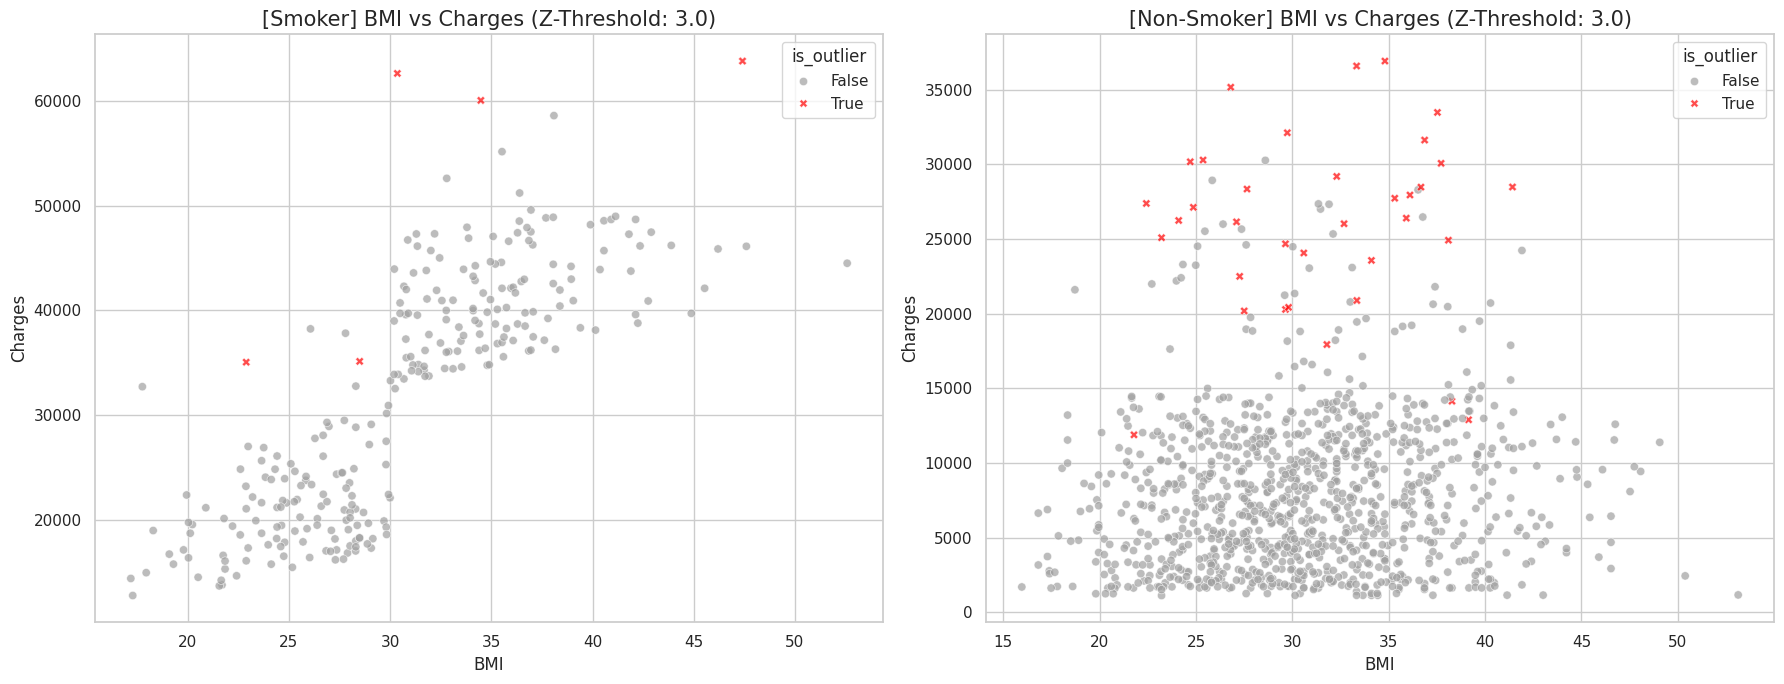

현재 설정된 임계값 X = 3.0
감지된 총 이상치 개수: 40개


In [21]:
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns

# 1. 데이터 로드
df = pd.read_csv('insurance.csv')

# ==========================================
# 2. 신뢰구간 임계값 설정 (변수 X)
# 예: 1.96 (95%), 2.58 (99%), 3.0 (강한 이상치)
Z_THRESHOLD = X
# ==========================================

# 3. 기초 전처리 (그룹화용)
df['age_group'] = (df['age'] // 10) * 10
bmi_bins = [0, 18.5, 25, 30, 35, float('inf')]
bmi_labels = ['Underweight', 'Normal', 'Overweight', 'Obese', 'Extremely Obese']
df['bmi_group'] = pd.cut(df['bmi'], bins=bmi_bins, labels=bmi_labels)

# 4. 변수 X를 적용한 이상치 탐지 함수
def flag_outliers_dynamic(group, threshold):
    if len(group) > 3:
        # 각 그룹 내에서 Z-score 계산
        z_scores = np.abs(stats.zscore(group['charges']))
        group['is_outlier'] = (z_scores > threshold)
    else:
        group['is_outlier'] = False
    return group

# 그룹별 적용 (age_group, smoker, bmi_group 기준)
df = df.groupby(['age_group', 'smoker', 'bmi_group'], group_keys=False).apply(
    lambda x: flag_outliers_dynamic(x, Z_THRESHOLD)
)

# 5. 시각화 (흡연/비흡연 분리 및 이상치 강조)
sns.set_theme(style="whitegrid")
fig, axes = plt.subplots(1, 2, figsize=(18, 7))
smoker_types = ['yes', 'no']

for i, smoker_val in enumerate(smoker_types):
    subset = df[df['smoker'] == smoker_val]
    title_status = "Smoker" if smoker_val == 'yes' else "Non-Smoker"

    sns.scatterplot(
        data=subset,
        x='bmi', # 대표로 BMI 기준 시각화
        y='charges',
        hue='is_outlier',
        palette={False: '#A0A0A0', True: '#FF0000'}, # 정상: 회색, 이상치: 빨간색
        style='is_outlier',
        markers={False: 'o', True: 'X'},
        alpha=0.7,
        ax=axes[i]
    )

    axes[i].set_title(f"[{title_status}] BMI vs Charges (Z-Threshold: {Z_THRESHOLD})", fontsize=15)
    axes[i].set_xlabel("BMI")
    axes[i].set_ylabel("Charges")

plt.tight_layout()
plt.show()

print(f"현재 설정된 임계값 X = {Z_THRESHOLD}")
print(f"감지된 총 이상치 개수: {df['is_outlier'].sum()}개")

##정규분포 신뢰구간별 제거되는 이상치 확인하기

In [22]:
#바꿔볼 정규분포 신뢰구간(90% = 1.645,95% = 1.96, 99% = 2.575, 99.7% = 3)
X=float(input('위의 주석을 참고해서 실수값을 넣어주세요'))

위의 주석을 참고해서 실수값을 넣어주세요2.575


/tmp/ipython-input-2938259418.py:30: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df = df.groupby(['age_group', 'smoker', 'bmi_group'], group_keys=False).apply(
/tmp/ipython-input-2938259418.py:30: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.groupby(['age_group', 'smoker', 'bmi_group'], group_keys=False).apply(


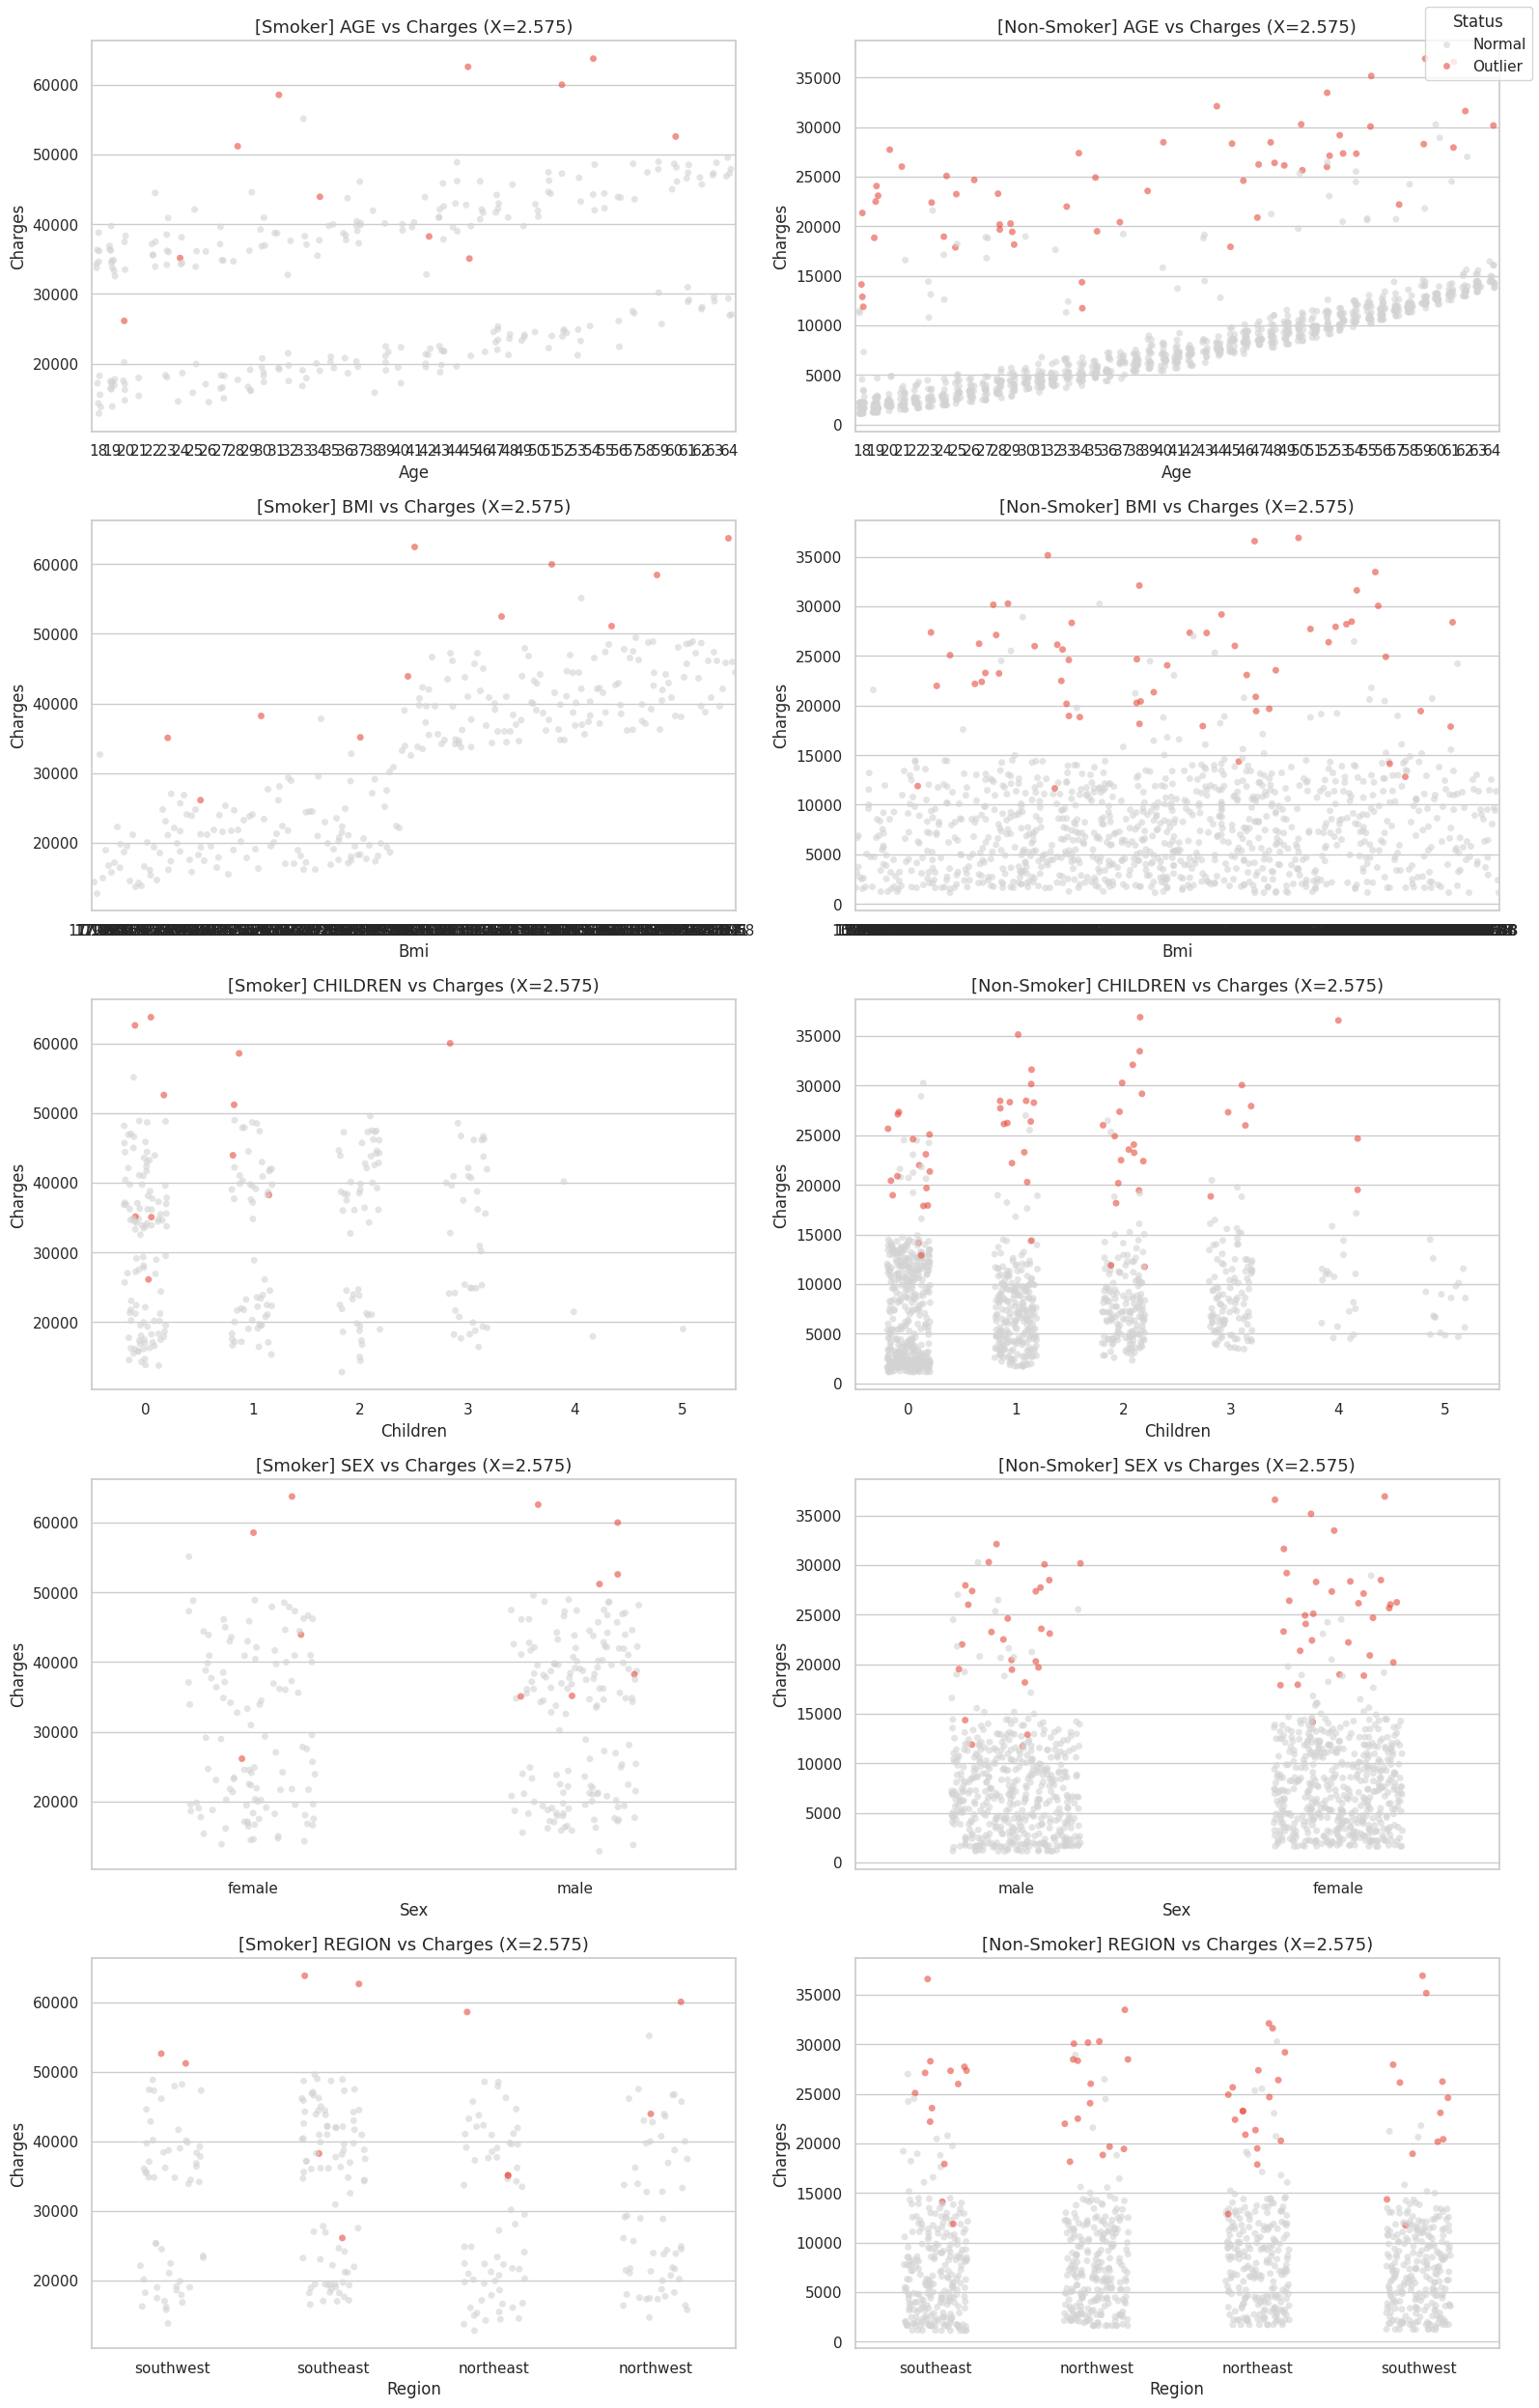

In [23]:
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns

# 1. 데이터 로드 및 기본 전처리
df = pd.read_csv('insurance.csv')

# ==========================================
# 2. 신뢰구간 임계값 설정 (변수 X)
Z_THRESHOLD = X
# ==========================================

# 그룹화용 파생 변수 생성
df['age_group'] = (df['age'] // 10) * 10
bmi_bins = [0, 18.5, 25, 30, 35, float('inf')]
bmi_labels = ['Underweight', 'Normal', 'Overweight', 'Obese', 'Extremely Obese']
df['bmi_group'] = pd.cut(df['bmi'], bins=bmi_bins, labels=bmi_labels)

# 3. 그룹별 이상치 탐지 함수 (X 적용)
def flag_outliers(group, threshold):
    if len(group) > 3:
        z_scores = np.abs(stats.zscore(group['charges']))
        group['is_outlier'] = (z_scores > threshold)
    else:
        group['is_outlier'] = False
    return group

df = df.groupby(['age_group', 'smoker', 'bmi_group'], group_keys=False).apply(
    lambda x: flag_outliers(x, Z_THRESHOLD)
)

# 4. 시각화 대상 컬럼 리스트 (수치형 + 범주형 포함)
features = ['age', 'bmi', 'children', 'sex', 'region']
smoker_types = ['yes', 'no']

# 그래프 생성 (컬럼 개수만큼 행 생성, 흡연 여부로 2열 구성)
fig, axes = plt.subplots(len(features), 2, figsize=(16, 5 * len(features)))

for i, col in enumerate(features):
    for j, smoker_val in enumerate(smoker_types):
        subset = df[df['smoker'] == smoker_val]
        status = "Smoker" if smoker_val == 'yes' else "Non-Smoker"

        # 산점도 그리기 (범주형 데이터는 약간의 노이즈(jitter)를 주어 겹침 방지)
        sns.stripplot(
            data=subset,
            x=col,
            y='charges',
            hue='is_outlier',
            palette={False: '#D3D3D3', True: '#E74C3C'}, # 회색 vs 빨간색
            alpha=0.6,
            jitter=0.2, # 범주형 컬럼에서 데이터가 겹치지 않게 퍼뜨림
            ax=axes[i, j],
            dodge=False
        )

        axes[i, j].set_title(f"[{status}] {col.upper()} vs Charges (X={Z_THRESHOLD})", fontsize=13)
        axes[i, j].set_xlabel(col.capitalize())
        axes[i, j].set_ylabel("Charges")
        axes[i, j].get_legend().remove() # 범례는 너무 많으니 일단 제거

# 우측 상단에 범례 하나만 표시
handles, labels = axes[0, 0].get_legend_handles_labels()
fig.legend(handles, ['Normal', 'Outlier'], loc='upper right', title='Status')

plt.tight_layout()
plt.show()